In [1]:
# Parameters
top_folder = "/Users/valenti/xai-nft/data/top_collections"


In [2]:
%load_ext autoreload
%autoreload 2
import sys
import os

# Set the new working directory
new_directory = '/Users/valenti/xai-nft/'

# Change the current working directory
os.chdir(new_directory)
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import random
import matplotlib.pyplot as plt
import shap
from xai.utils.data import save_json
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import r2_score, explained_variance_score
from sklearn.model_selection import KFold


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
np.random.seed(42)
random.seed(42)

In [4]:
df_t = pd.read_parquet(os.path.join(top_folder, 'asset_traits.parquet'), engine='pyarrow')
df_a = pd.read_parquet(os.path.join(top_folder, 'assets.parquet'), engine='pyarrow')

df_s = pd.read_parquet(os.path.join(top_folder, 'sales_with_trend.parquet'), engine='pyarrow')

df_s = df_s[~df_s['outlier']]
df_s = df_s.dropna(subset=["timestamp", 'price_eth'])
df_s.head()

,asset_id,token_id,asset_contract_address,collection,image_url,image_preview_url,image_thumbnail_url,currency_symbol,asset_bundle,event_timestamp,...,usd_price,quantity,decimals,price_eth,timestamp,origin,price_eth_trend_100,price_eth_scaled_100,price_eth_scaled_std_100,outlier
17695,22697922,33,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,boredapeyachtclub,None,None,None,WETH,NaN,2021-04-30T12:38:59,...,3242.340000000000146000,1.0,18.0,0.16,2021-04-30 12:38:59,events,0.1,139.2,258.342626,False
6329,23115057,586,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,boredapeyachtclub,None,None,None,ETH,NaN,2021-05-01T00:15:48,...,3250.019999999999982000,1.0,18.0,0.10,2021-05-01 00:15:48,events,0.1,87.0,258.342626,False
6328,23113936,554,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,boredapeyachtclub,None,None,None,ETH,NaN,2021-05-01T00:50:09,...,3250.019999999999982000,1.0,18.0,0.08,2021-05-01 00:50:09,events,0.1,69.6,258.342626,False
6327,23116949,665,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,boredapeyachtclub,None,None,None,ETH,NaN,2021-05-01T00:51:32,...,3250.019999999999982000,1.0,18.0,0.08,2021-05-01 00:51:32,events,0.1,69.6,258.342626,False
6326,23113930,551,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,boredapeyachtclub,None,None,None,ETH,NaN,2021-05-01T00:51:32,...,3250.019999999999982000,1.0,18.0,0.08,2021-05-01 00:51:32,events,0.1,69.6,258.342626,False


In [5]:
df_t_s = df_t.copy()

In [6]:
df_t_s['frequency'] = df_t_s['trait_count'] / 10000
ranks = df_t_s['trait_type'].unique()
ranks = sorted(ranks)
ranks = {
    r: i for i,r in enumerate(ranks)
}
df_t_s['rank'] = df_t_s['trait_type'].map(ranks)

In [7]:
df_features = df_t_s.set_index(['asset_id', 'trait_type'])['trait_value'].unstack()
feature_names = list(df_features.columns)
feature_names

['Background',
 'Clothes',
 'Earring',
 'Eyes',
 'Fur',
 'Hat',
 'Mouth',
 'TraitCount']

In [8]:
df_s['event_timestamp'].max()

'2023-09-17T14:17:59'

In [9]:
target = 'price_eth_scaled_100'

one_hot_encoder = OneHotEncoder().fit(df_features)

training_start = datetime.datetime.fromisoformat('2022-04-01')
training_end = datetime.datetime.fromisoformat('2023-04-01')
exp_start = datetime.datetime.fromisoformat('2023-04-01')
exp_end = datetime.datetime.fromisoformat('2023-07-01')


df_training = df_s[(df_s['timestamp'] >= training_start) & (df_s['timestamp'] < training_end)]
y_training = df_training.groupby('asset_id')[target].median()

cvscores = []

# calculate cv score,
kf = KFold(n_splits=6, shuffle=True)
for cv_idx, (train, test) in enumerate(kf.split(y_training)):
    y_train = y_training.iloc[train]
    y_test = y_training.iloc[test]
    x_train = df_features.loc[y_train.index].copy()
    x_train_enc = one_hot_encoder.transform(x_train)
    x_test = df_features.loc[y_test.index].copy()
    x_test_enc = one_hot_encoder.transform(x_test)
    model = ElasticNet(alpha=0.05, l1_ratio=1)
    model.fit(x_train_enc, y_train)
    

    train_pred = model.predict(x_train_enc)
    test_pred = model.predict(x_test_enc)
    this_scores = [
        dict(cv=cv_idx, name='r2', set='train', value=r2_score(y_train, train_pred)),
        dict(cv=cv_idx, name='r2', set='test', value=r2_score(y_test, test_pred)),
        dict(cv=cv_idx, name='explained variance', set='train', value=explained_variance_score(y_train, train_pred)),
        dict(cv=cv_idx, name='explained variance', set='test',  value=explained_variance_score(y_test, test_pred)),
    ]
    cvscores.extend(this_scores)

x_training = df_features.loc[y_training.index]
x_training_enc = one_hot_encoder.transform(x_training)
model.fit(x_training_enc, y_training)
train_pred = model.predict(x_training_enc)

train_output = pd.DataFrame(
    {
        'train_target': y_training,
        'train_prediction': train_pred,
    },
    index=y_training.index,
)


# predict
df_exp = df_s[(df_s['timestamp'] >= exp_start) & (df_s['timestamp'] < exp_end)]
y_exp = df_exp.groupby('asset_id')[target].median()
x_exp = df_features.loc[y_exp.index]
x_exp_enc = one_hot_encoder.transform(x_exp)

exp_pred = model.predict(x_exp_enc)

exp_output = pd.DataFrame(
    {
        'exp_target': y_exp,
        'exp_prediction': exp_pred,
    },
    index=y_exp.index,
)

joined_output = train_output.join(exp_output, how='outer')



is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


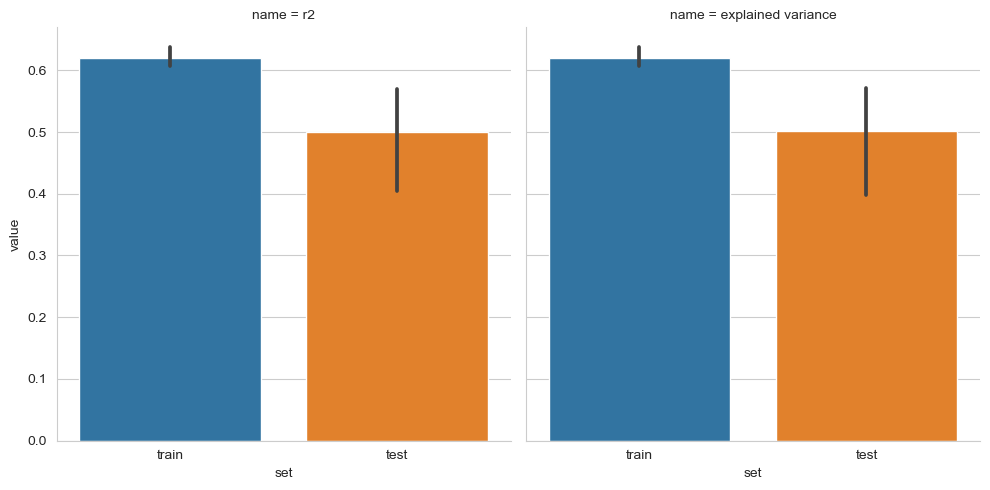

In [10]:
scores_df = pd.DataFrame.from_records(cvscores)
sns.set_style('whitegrid')
sns.catplot(data=scores_df, y='value', x='set', col='name', kind='bar')

## Mask of the Dataframe

In [11]:
X_encoded = one_hot_encoder.transform(x_training).toarray()

new_feature_names = one_hot_encoder.get_feature_names_out()

X = pd.DataFrame(X_encoded, columns= new_feature_names, index=x_training.index)

def filter_row_by_asset_id(asset_id):
    # Select the row with the given asset_id
    selected_row = X.loc[asset_id]

    # Filter the row to keep only columns with a value of 1.0
    filtered_row = selected_row[selected_row == 1.0]

    # Convert the filtered row to a DataFrame with a single row
    present_binary_features = filtered_row.to_frame().T

    return present_binary_features
    



## SHAP Explainability

In [12]:


explainer = shap.Explainer(model, x_training_enc)

# Calculate SHAP values for all asset_ids
shap_values = explainer.shap_values(x_training_enc)

# Create a DataFrame to store SHAP values, indexed by asset_id
shap_df = pd.DataFrame(shap_values, columns= one_hot_encoder.get_feature_names_out(), index=x_training.index)




shap_df

,Background_Aquamarine,Background_Army Green,Background_Blue,Background_Gray,Background_New Punk Blue,Background_Orange,Background_Purple,Background_Yellow,Clothes_Admirals Coat,Clothes_Bandolier,...,Mouth_Phoneme Oh,Mouth_Phoneme Vuh,Mouth_Phoneme Wah,Mouth_Rage,Mouth_Small Grin,Mouth_Tongue Out,TraitCount_4,TraitCount_5,TraitCount_6,TraitCount_7
asset_id,,,,,,,,,,,,,,,,,,,,,
22646195,0.0,-0.0,-0.0,0.0,-0.052355,-0.292083,0.008652,0.0,0.0,0.0,...,0.06002,0.025058,0.0,0.0,-0.0,-0.000000,-0.385996,0.390959,-0.426954,-0.148677
22646197,0.0,0.0,-0.0,0.0,-0.052355,-0.292083,0.008652,-0.0,0.0,0.0,...,0.06002,0.025058,0.0,0.0,-0.0,-0.000000,-0.385996,0.390959,-0.426954,-0.148677
22646204,-0.0,0.0,-0.0,0.0,-0.052355,-0.292083,0.008652,0.0,0.0,0.0,...,0.06002,0.025058,0.0,0.0,-0.0,-0.000000,-0.385996,0.390959,-0.426954,-0.148677
22646208,0.0,0.0,-0.0,0.0,-0.052355,-0.292083,-0.049029,0.0,0.0,0.0,...,0.06002,0.025058,0.0,0.0,0.0,-0.000000,-0.385996,0.390959,0.521833,0.842503
22646231,0.0,0.0,-0.0,0.0,0.529363,-0.292083,0.008652,0.0,0.0,0.0,...,0.06002,0.025058,0.0,0.0,-0.0,-0.000000,-0.385996,0.390959,0.521833,0.842503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23143737,0.0,-0.0,-0.0,0.0,-0.052355,-0.292083,0.008652,0.0,0.0,0.0,...,0.06002,0.025058,0.0,0.0,-0.0,-0.000000,-0.385996,0.390959,-0.426954,-0.148677
23143739,0.0,0.0,-0.0,0.0,0.529363,-0.292083,0.008652,0.0,0.0,0.0,...,0.06002,-1.227843,0.0,0.0,-0.0,-0.000000,-0.385996,-1.005322,0.521833,-0.148677
23143744,0.0,0.0,-0.0,0.0,-0.052355,1.954711,0.008652,0.0,0.0,0.0,...,0.06002,0.025058,0.0,0.0,-0.0,-0.000000,-0.385996,-1.005322,0.521833,-0.148677


In [13]:


dfs_to_concat = []

# Iterate through each asset_id
for asset_id, group in shap_df.iterrows():
    # Initialize a dictionary to store the aggregated feature values
    aggregated_features = {'asset_id': asset_id}

    # Iterate through each feature in the feature list
    for feature in feature_names:
        # Extract the non-null values for the current feature and asset
        non_null_values = [group[x] for x in group.index if feature in x and not pd.isnull(group[x])]

        # Calculate the sum of non-null values for the current feature
        sum_value = sum(non_null_values)

        # Store the sum value as the value of the current feature for the asset_id
        aggregated_features[feature] = sum_value

    
    dfs_to_concat.append(pd.DataFrame(aggregated_features, index=[0]))

aggregated_features_df = pd.concat(dfs_to_concat, ignore_index=True)

aggregated_features_df





,asset_id,Background,Clothes,Earring,Eyes,Fur,Hat,Mouth,TraitCount
0,22646195,-0.335786,4.541194,-0.432703,1.073814,-2.997816,13.488720,-2.620486,-0.570669
1,22646197,-0.335786,0.601619,-0.432703,-5.607881,-0.876305,-1.416192,-2.669726,-0.570669
2,22646204,-0.335786,-1.155212,0.037873,1.352766,-0.391119,-1.416192,-2.669726,-0.570669
3,22646208,-0.393467,-1.414707,-0.432703,-0.210750,-2.997816,-1.764653,-1.116289,1.369299
4,22646231,0.245932,1.163367,0.037873,-1.402449,-2.968907,-3.113355,-2.385204,1.369299
...,...,...,...,...,...,...,...,...,...
2689,23143737,-0.335786,-1.155212,-0.432703,-0.464078,-0.503100,-1.416192,-2.385204,-0.570669
2690,23143739,0.245932,-1.155212,-0.432703,-1.380612,-2.802551,-1.416192,-2.369190,-1.018162
2691,23143744,1.911009,-1.155212,-0.432703,1.125274,-1.541063,-0.472927,-2.385204,-1.018162
2692,23143749,-0.335786,-1.155212,-0.432703,-5.607881,-1.541063,-1.416192,-2.385204,1.369299


## Local Explanations

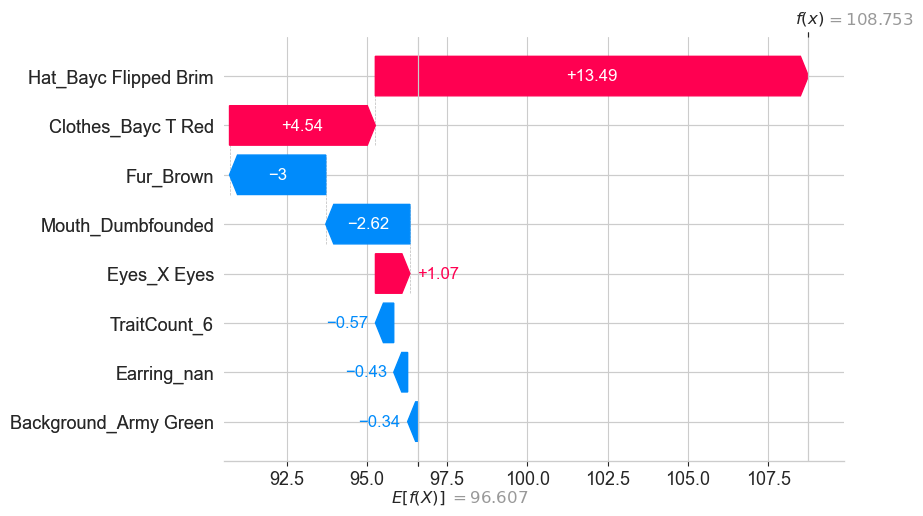

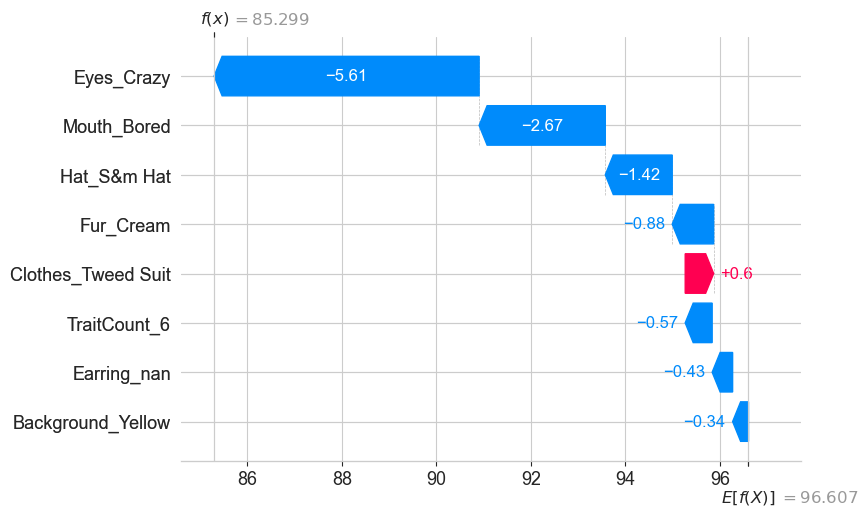

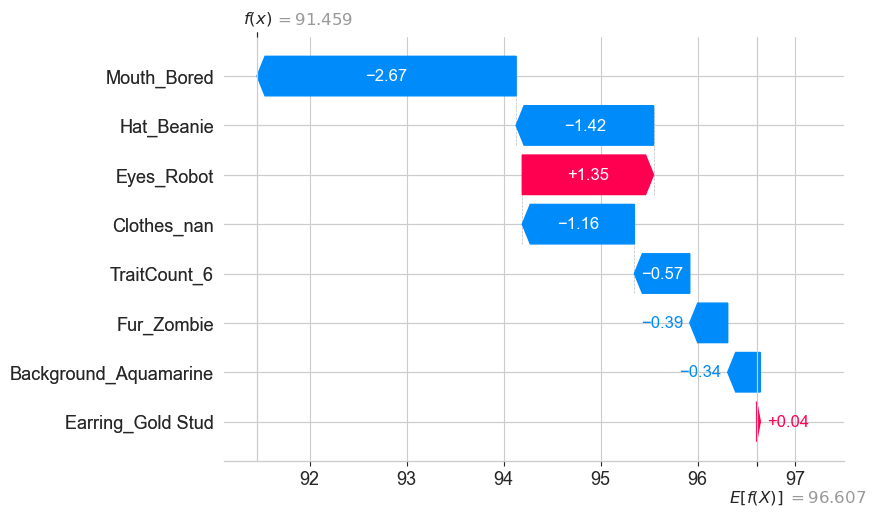

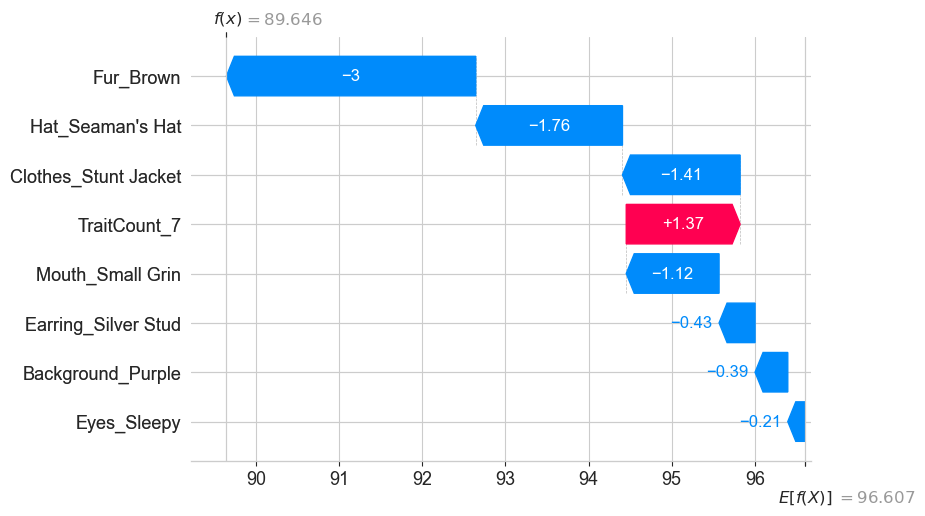

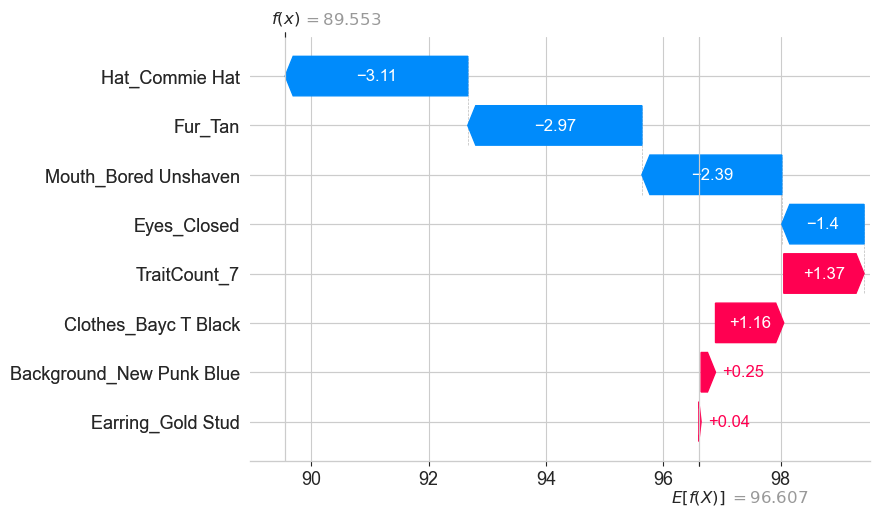

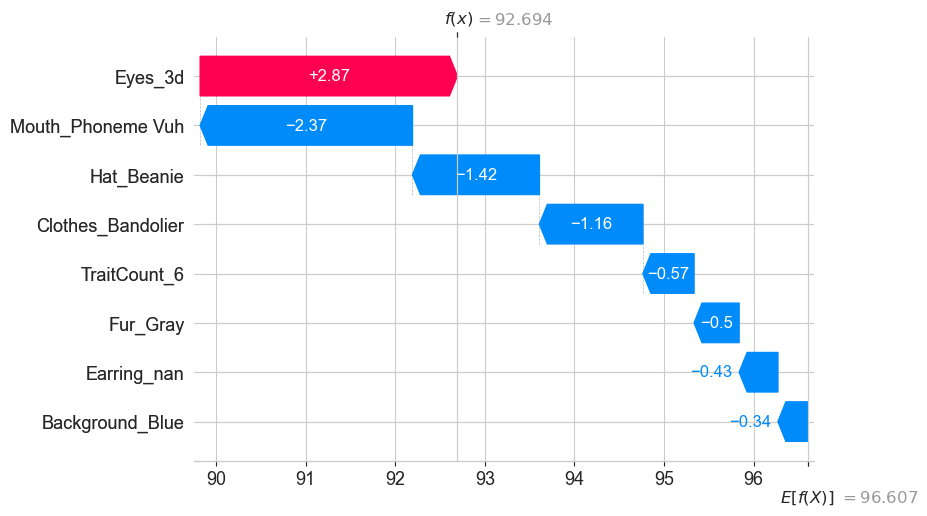

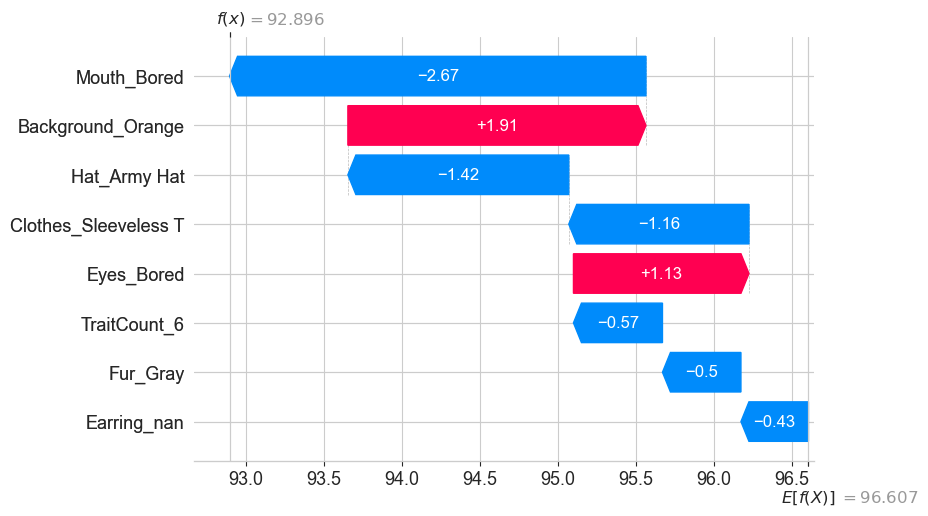

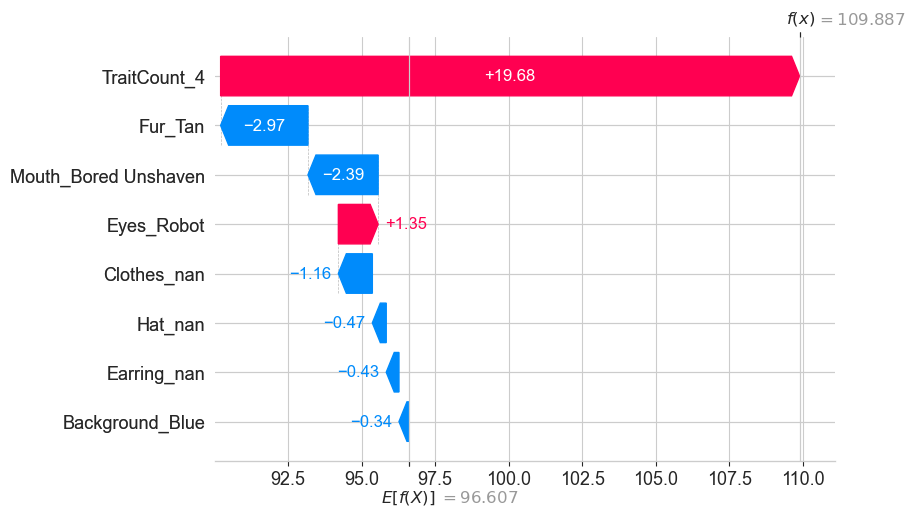

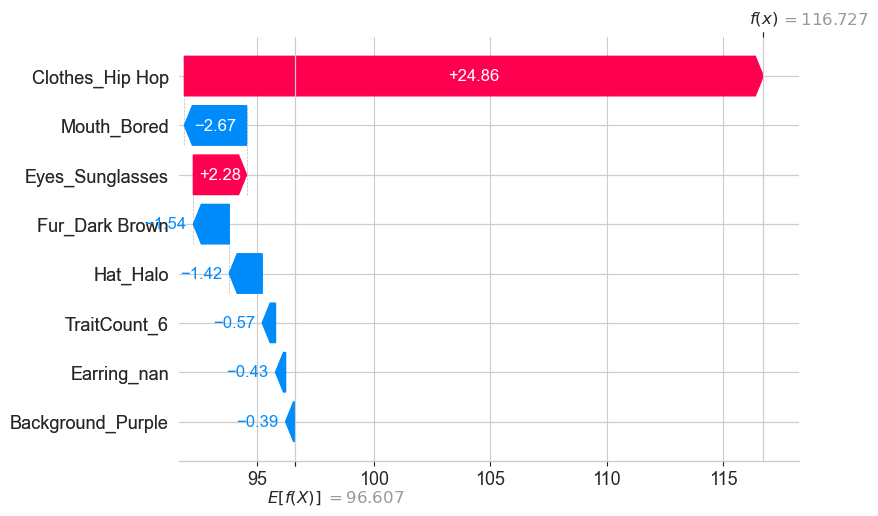

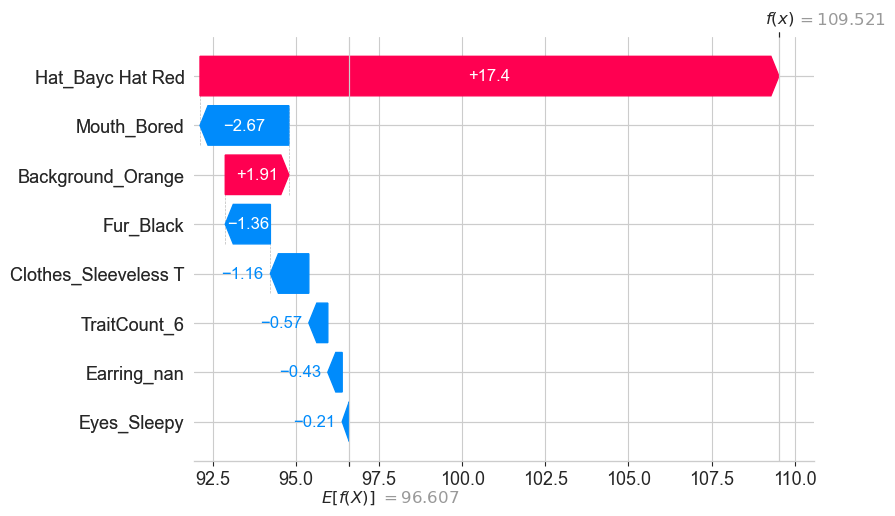

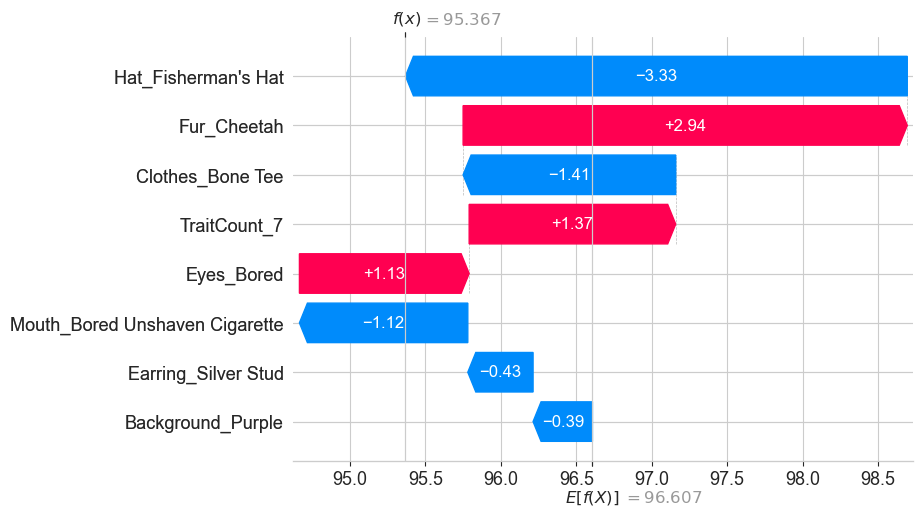

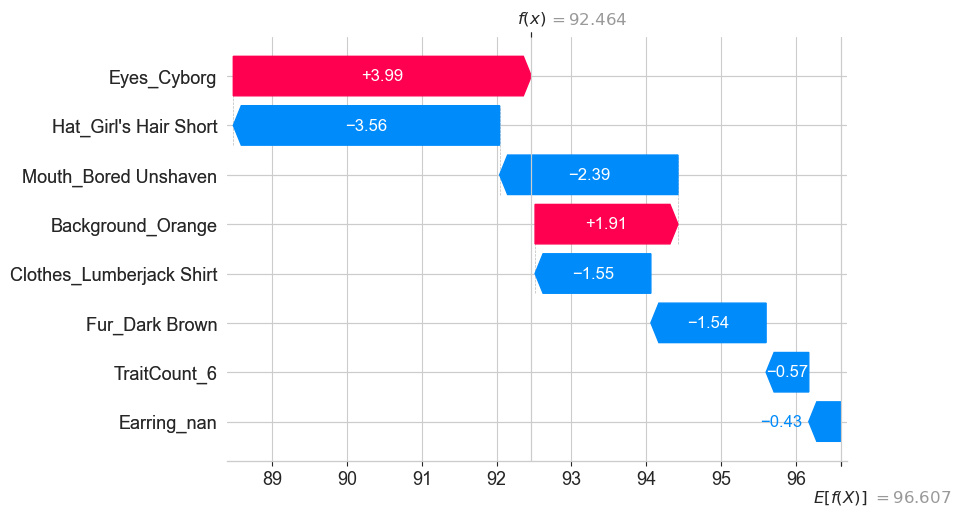

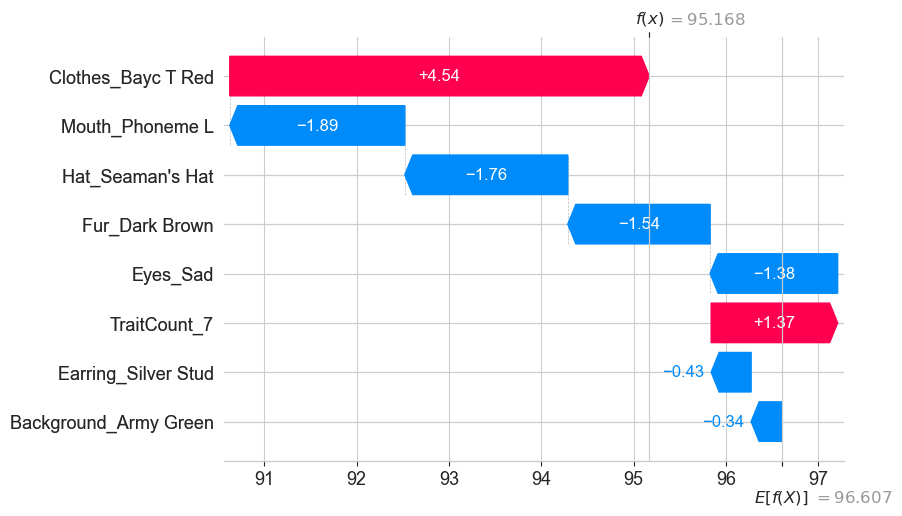

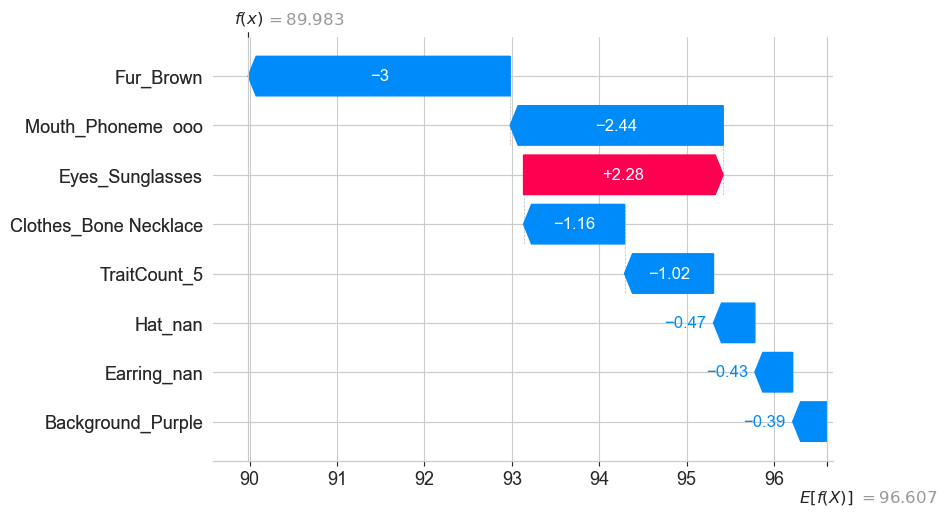

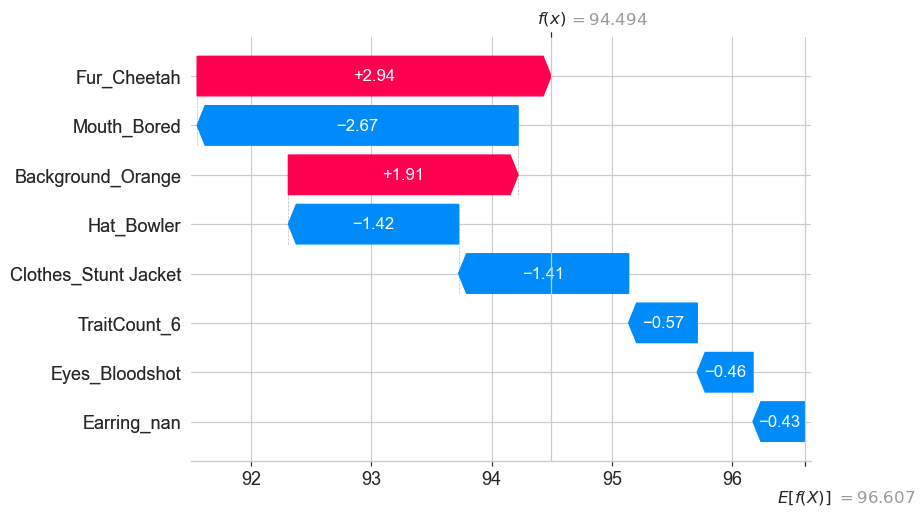

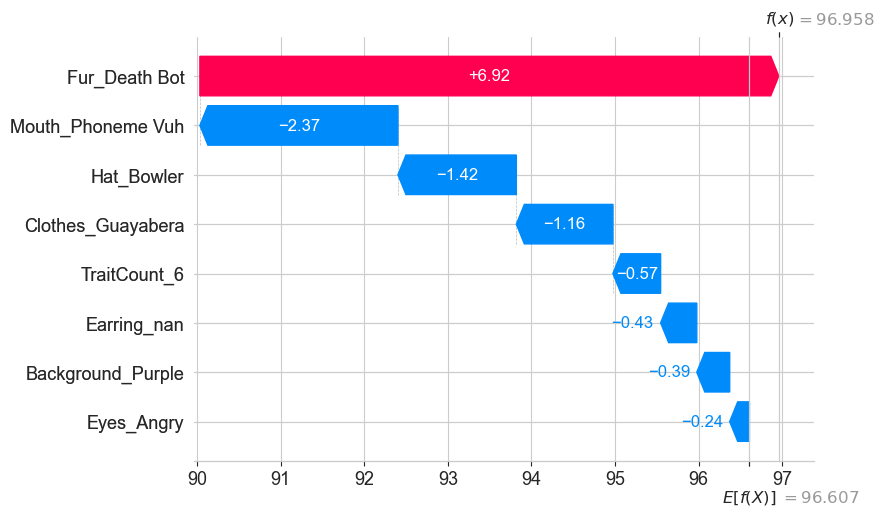

KeyboardInterrupt: 

In [15]:
# Initialize an empty list to store the feature values
shap_global = []

# Iterate through each row in the aggregated_features_df
for index, row in aggregated_features_df.iterrows():
    # Extract the asset_id and feature values
    asset_id = row['asset_id']
    present_binary_features = list(filter_row_by_asset_id(asset_id).columns)
    feature_values = row[feature_names].values

    # Append the feature values to the shap_global list
    shap_global.append(feature_values)

    # Generate the SHAP waterfall plot with custom labels and title
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value, feature_values,
                                          feature_names=present_binary_features)

    # Ensure tight layout to prevent clipping of labels
    plt.tight_layout()

    # Save the plot with the asset_id as the filename
    #output_filename = os.path.join(output_folder, f'shap_values_asset_{asset_id}.png')
    #plt.savefig(output_filename)
    #plt.close()

# Convert the list of feature values to a NumPy array
shap_global = np.array(shap_global)



## Global Explanation

In [16]:
x_training_transformed = x_training.copy()

# Create a custom label encoding dictionary
label_encoding = {}

for column in x_training_transformed.columns:
    if len(x_training_transformed[column].unique()) > 2:
        
        # For non-binary categorical features, use label encoding
        label_encoding[column] = {value: i for i, value in enumerate(x_training_transformed[column].dropna().unique())}
        x_training_transformed[column] = x_training_transformed[column].map(label_encoding[column])


# Remove the "asset_id" column
aggregated_features = aggregated_features_df.drop(columns=['asset_id'])


result_array = aggregated_features.to_numpy()
Shap_values = explainer(X_encoded)

# Substitute shap_values with result_array
Shap_values.values = result_array

# Update base_values and data
Shap_values.base_values = np.array([96.60685033] * len(X_encoded))
data_to_array = x_training_transformed.to_numpy()
Shap_values.data = data_to_array

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


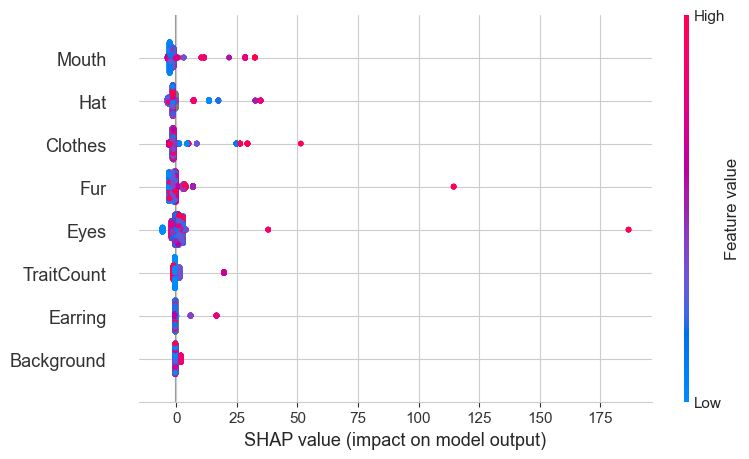

In [17]:
# Create a custom color gradient from blue to red
custom_cmap = plt.get_cmap("coolwarm")
# Assuming you have already defined Shap_values and feature_names as in your code
# Plot the SHAP summary plot using the custom color gradient
shap.summary_plot(Shap_values, feature_names=feature_names, show=False)

# Display the plot
plt.show()
 

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


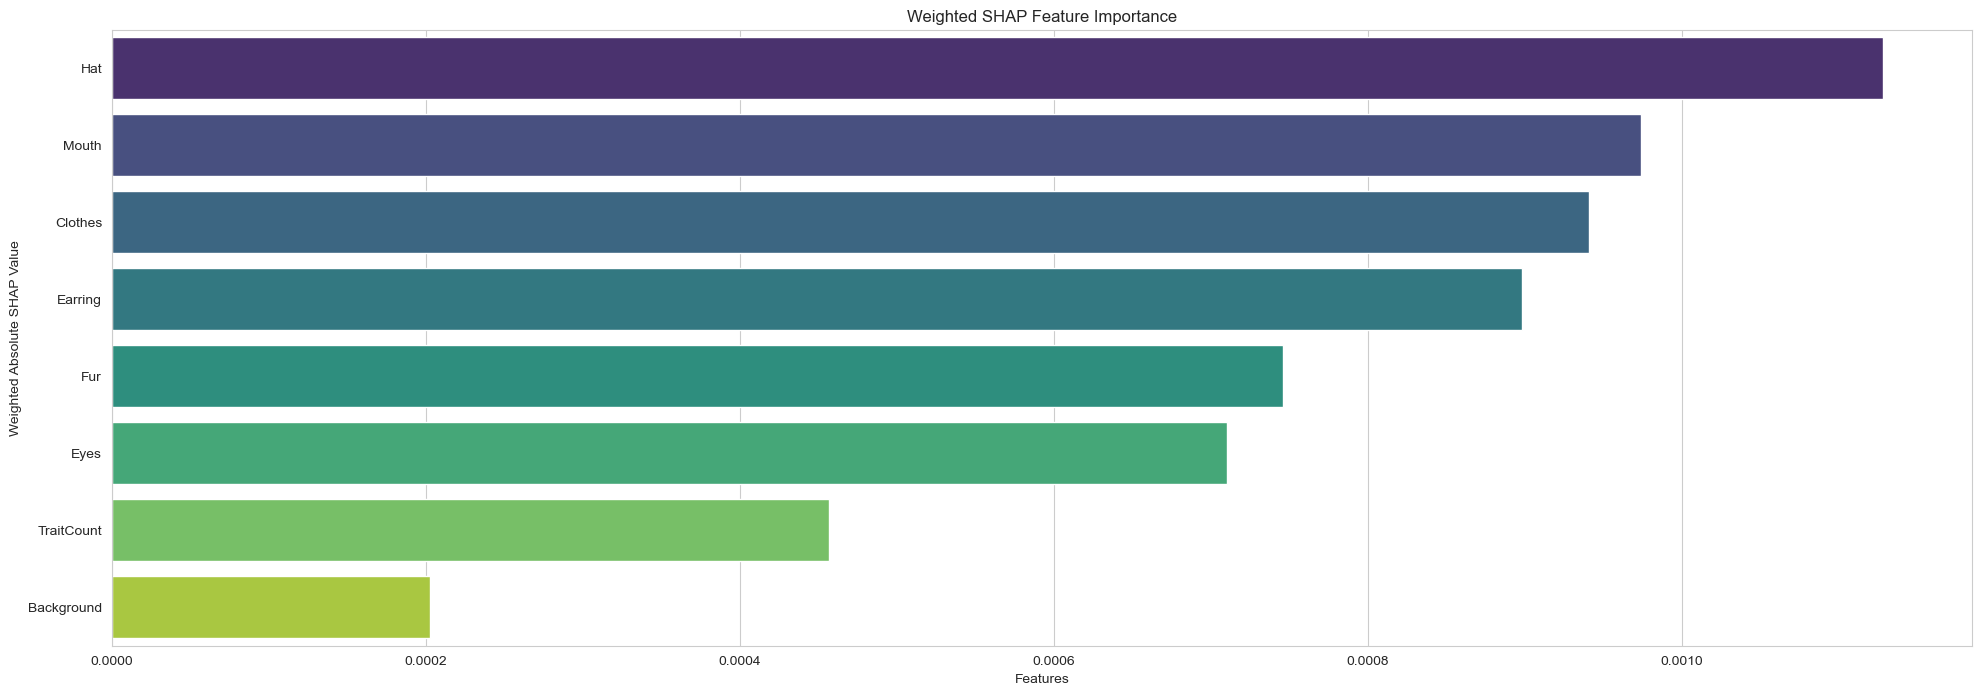

In [18]:

feature_weights = {}


for feature in feature_names:
    
    # Count the number of times that feature is present in x_training
    number_features_present = x_training[feature].count()
    
    
    # Update the weight dictionary with the feature count
    feature_weights[feature] = number_features_present


weighted_shap_values = []


for feature in feature_names:
    
    # Calculate the average absolute SHAP value for the current feature
    avg_absolute_shap = aggregated_features_df[feature].abs().mean()
    
    # Get the count of instances for the current feature from the feature_weights dictionary
    feature_count = feature_weights[feature]
    
    # Calculate the weighted absolute SHAP value by dividing the average SHAP value by the count of instances
    weighted_shap_value = avg_absolute_shap / feature_count
    
    weighted_shap_values.append((feature, weighted_shap_value))

# Sort the weighted SHAP values in descending order
weighted_shap_values.sort(key=lambda x: x[1], reverse=True)

# Extract feature names and weighted absolute SHAP values for the plot
feature_names = [x[0] for x in weighted_shap_values]
weighted_shap_values = [x[1] for x in weighted_shap_values]


plt.figure(figsize=(24, 8))


sns.barplot(x=weighted_shap_values, y=feature_names, palette="viridis")


plt.title('Weighted SHAP Feature Importance')
plt.xlabel('Features')
plt.ylabel('Weighted Absolute SHAP Value')


plt.show()


In [19]:
feature_weights

{'Background': 2694,
 'Clothes': 2210,
 'Earring': 787,
 'Eyes': 2694,
 'Fur': 2694,
 'Hat': 2082,
 'Mouth': 2694,
 'TraitCount': 2694}

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


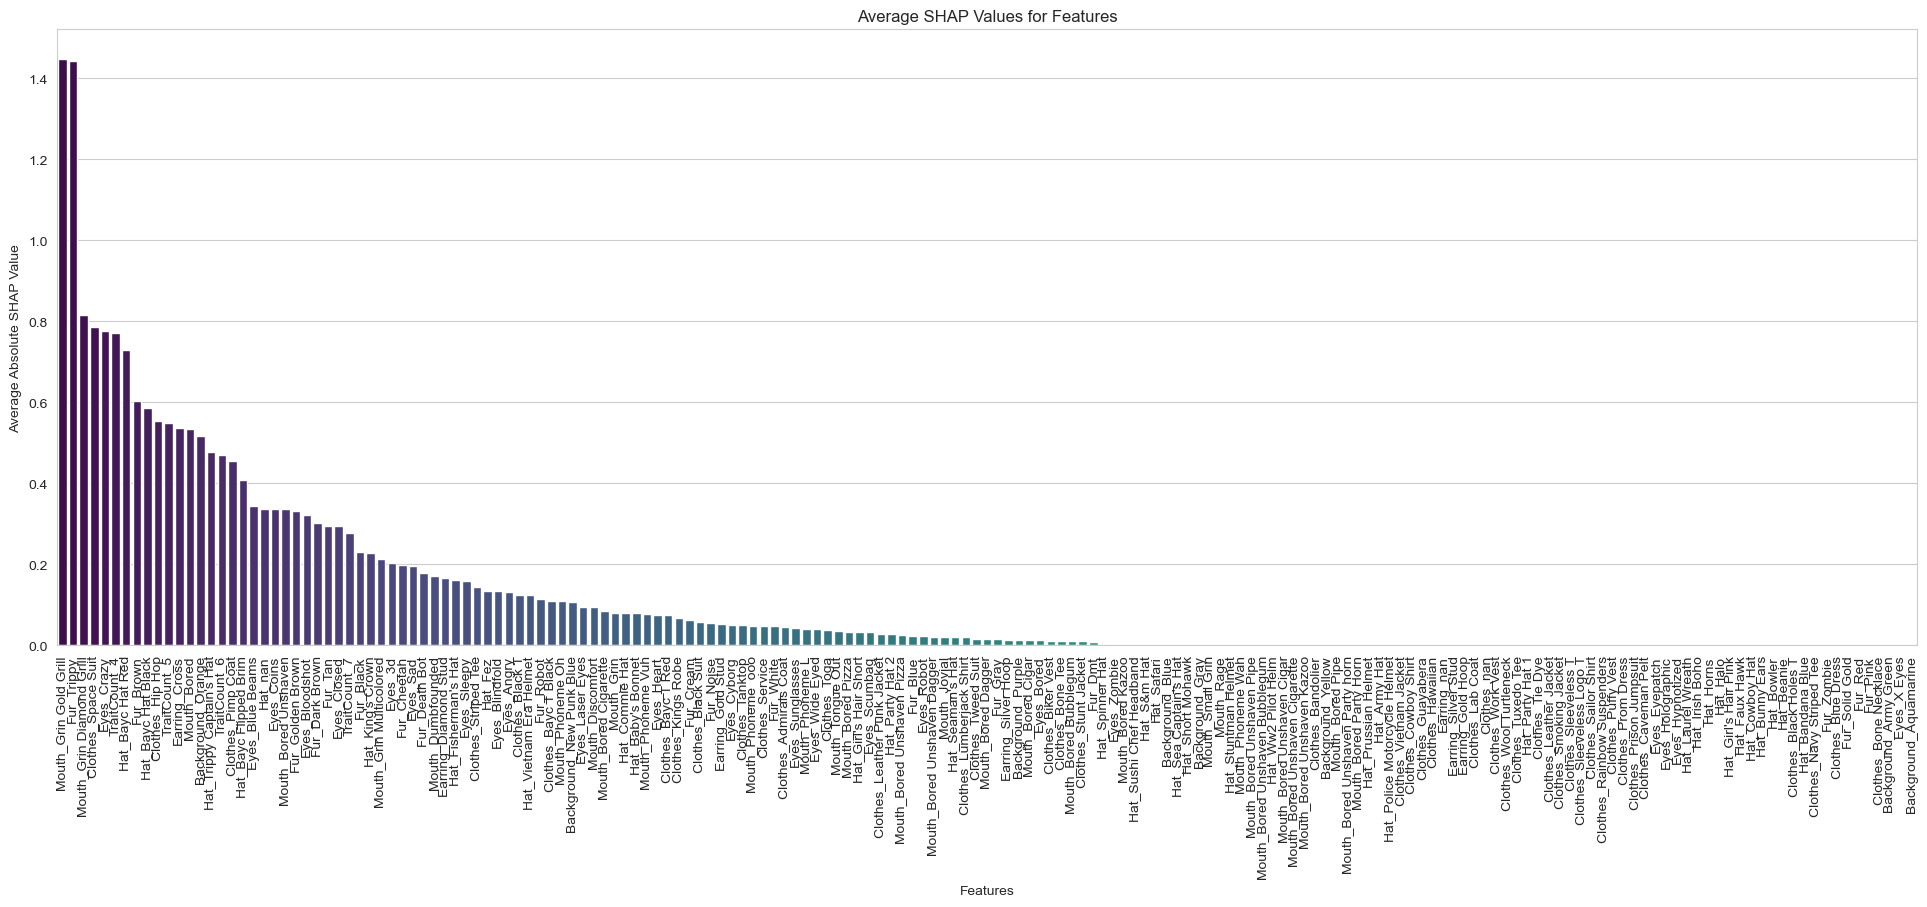

In [20]:

# Calculate the average SHAP values for features
average_shap_values = shap_df.abs().mean(axis=0).sort_values(ascending=False)


plt.figure(figsize=(24, 8))

sns.barplot(x=average_shap_values.index, y=average_shap_values.values, palette="viridis")


plt.title('Average SHAP Values for Features')
plt.xlabel('Features')
plt.ylabel('Average Absolute SHAP Value')


plt.xticks(rotation=90)
plt.show()


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


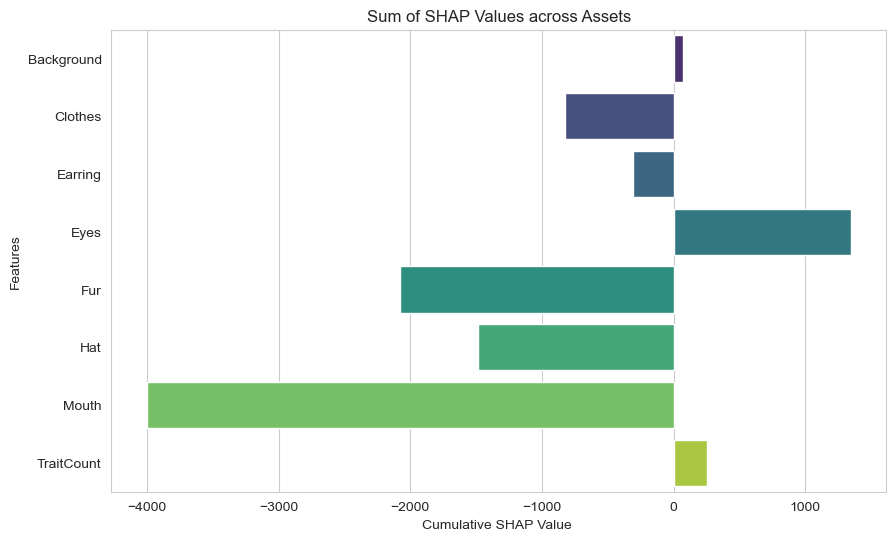

In [21]:
# Calculate the sum of SHAP values for each feature (excluding the asset_id column)
sum_shap_values = aggregated_features_df.drop(columns=['asset_id']).sum()


plt.figure(figsize=(10, 6))
sns.barplot(x=sum_shap_values.values, y=sum_shap_values.index, palette='viridis')


plt.xlabel('Cumulative SHAP Value ')
plt.ylabel('Features')
plt.title('Sum of SHAP Values across Assets')


plt.show()

In [ ]:
df_at = df_t_s.groupby('asset_id')[
    ['trait_type', 'trait_value', 'trait_count', 'rarity_score', 'frequency', 'rank']].apply(lambda df: df.to_dict(orient='records'))

df_aa = df_a.set_index('asset_id')[
    ['token_id', 'collection', 'image_url', 'image_preview_url', 'image_thumbnail_url']]

df = df_aa.copy()
df['traits'] = df_at
df['history_eth'] = joined_output['train_target']
df['sales_eth'] = joined_output['exp_target']
df['pred_eth'] = joined_output['exp_prediction']

df = df[~(df['history_eth'].isna() & df['sales_eth'].isna())]

df_sales = df.copy()

df[['history_eth','sales_eth','pred_eth']] = df[['history_eth','sales_eth','pred_eth']].fillna(-1.)

save_json(df.to_dict(orient='records'), os.path.join(top_folder, 'frontend_data.json'))